In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima


%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# ARIMAX Time Series Modelling
- [Reading in Data](#read) 
- [Instantiating X and Y & Train/Test Splitting](#traintest)
- [Examining Trends](#trends)
- [Examining Seasonality](#season)
- [Selecting P, Q, and D for ARIMAX Modelling](#pqd)
    - [Selecting D](#d)
    - [Selecting P](#p)
    - [Selecting Q](#q)
    - [Using Auto Arima to Verify Selection](#auto)
- [Instantiating ARIMAX Model & Summary Statistics](#arimax)
- [Plotting Predictions](#preds)
    -[Evaluating Predictions](#eval)
- [Plotting Residuals](#resid)
- [Analysis & Findings](#analysis)

# Reading in Data<a id='read'></a> 

In [2]:
df = pd.read_csv('../Data/Infrastructure/mex_final_df.csv')

In [3]:
df.head()

,Year,ICT goods exports (% of total goods exports),Individuals using the Internet (% of population),Fixed telephone subscriptions (per 100 people),"Air transport, freight (million ton-km)","Industrial design applications, nonresident, by count",Public private partnerships investment in water and sanitation (current US$),Public private partnerships investment in transport (current US$),Electricity production from natural gas sources (% of total),"ICT service exports (% of service exports, BoP)",Healthcare Expenditure Percent GDP,Pharmaceutical Spending US $ / Capita,CT Scan Device Counts,PET Scan Device Counts,Doctors per 1000 People,Nurses per 1000 People,Hospital Count,Total Cases
0,1999,18.507953,1.857436,11.209318,317.000,976,173600000.0,370200000,18.809984,10.129306,4.395,88.193,200,0,1.67,2.14,3940,8645
1,2000,20.909537,5.081384,12.468853,309.858,1258,375763333.3,793600000,21.455695,8.997126,4.449,100.973,220,0,1.59,2.19,3952,4277
2,2001,22.061841,7.038023,13.733200,295.884,973,72000000.0,223800000,26.020151,6.325090,4.820,110.626,250,0,1.49,2.19,3978,4675
3,2002,20.739979,11.900000,14.726971,341.598,1208,375763333.3,71400000,34.166739,4.442751,5.072,127.529,296,0,1.50,2.19,4088,4506
4,2003,19.311210,12.900000,15.841972,350.089,1162,375763333.3,74700000,40.143173,3.397368,5.815,242.818,309,0,1.55,2.10,4150,5101


In [4]:
# Create an array called "dates" based on "year" and converting to string.
dates = df[['Year']].astype(int).astype(str)

#creating year variable to use below
yearly = dates["Year"]

#getting date from our year column
yearly = dates_from_str(yearly)

#converting our yearly var to datetime and making it our index
df.index = pd.DatetimeIndex(yearly)

#getting rid of year column because it is indexed
df.drop(axis = 0, columns = ['Year'], inplace = True)

#casting all as same datatype
df = df.astype('float')

In [5]:
df

,ICT goods exports (% of total goods exports),Individuals using the Internet (% of population),Fixed telephone subscriptions (per 100 people),"Air transport, freight (million ton-km)","Industrial design applications, nonresident, by count",Public private partnerships investment in water and sanitation (current US$),Public private partnerships investment in transport (current US$),Electricity production from natural gas sources (% of total),"ICT service exports (% of service exports, BoP)",Healthcare Expenditure Percent GDP,Pharmaceutical Spending US $ / Capita,CT Scan Device Counts,PET Scan Device Counts,Doctors per 1000 People,Nurses per 1000 People,Hospital Count,Total Cases
1999-12-31,18.507953,1.857436,11.209318,317.000000,976.0,1.736000e+08,3.702000e+08,18.809984,10.129306,4.395,88.193,200.0,0.0,1.67,2.14,3940.0,8645.0
2000-12-31,20.909537,5.081384,12.468853,309.858000,1258.0,3.757633e+08,7.936000e+08,21.455695,8.997126,4.449,100.973,220.0,0.0,1.59,2.19,3952.0,4277.0
2001-12-31,22.061841,7.038023,13.733200,295.884000,973.0,7.200000e+07,2.238000e+08,26.020151,6.325090,4.820,110.626,250.0,0.0,1.49,2.19,3978.0,4675.0
2002-12-31,20.739979,11.900000,14.726971,341.598000,1208.0,3.757633e+08,7.140000e+07,34.166739,4.442751,5.072,127.529,296.0,0.0,1.50,2.19,4088.0,4506.0
2003-12-31,19.311210,12.900000,15.841972,350.089000,1162.0,3.757633e+08,7.470000e+07,40.143173,3.397368,5.815,242.818,309.0,0.0,1.55,2.10,4150.0,5101.0
2004-12-31,19.684402,14.100000,17.292494,394.925000,1555.0,4.217000e+08,4.856000e+08,42.792624,3.082827,5.954,264.753,289.0,0.0,1.63,2.08,4110.0,961.0
2005-12-31,17.988816,17.210000,18.406666,390.425000,1790.0,3.000000e+07,1.321300e+09,40.133510,3.482021,5.836,270.915,325.0,0.0,1.75,2.18,4243.0,6661.0
2006-12-31,18.769373,19.520000,18.465294,456.958000,1982.0,5.310000e+07,2.744430e+09,46.325087,3.343793,5.655,282.052,344.0,0.0,1.87,2.20,4245.0,2940.0
2007-12-31,17.713619,20.810000,18.318046,482.340000,1939.0,3.065000e+08,6.146400e+09,49.797943,2.753846,5.766,292.359,403.0,0.0,1.91,2.27,4344.0,6151.0
2008-12-31,19.534464,21.710000,18.491522,482.785000,1993.0,3.890000e+07,9.050800e+08,52.096987,2.260716,5.699,295.853,446.0,0.0,1.94,2.30,4379.0,559.0


In [6]:
#these are our final X variables (exogenous features)
df.columns

Index(['ICT goods exports (% of total goods exports)',
       'Individuals using the Internet (% of population)',
       'Fixed telephone subscriptions (per 100 people)',
       'Air transport, freight (million ton-km)',
       'Industrial design applications, nonresident, by count',
       'Public private partnerships investment in water and sanitation (current US$)',
       'Public private partnerships investment in transport (current US$)',
       'Electricity production from natural gas sources (% of total)',
       'ICT service exports (% of service exports, BoP)',
       'Healthcare Expenditure Percent GDP',
       'Pharmaceutical Spending US $ / Capita', 'CT Scan Device Counts',
       'PET Scan Device Counts', 'Doctors per 1000 People',
       'Nurses per 1000 People', 'Hospital Count', 'Total Cases'],
      dtype='object')

# Instantiating X and Y<a id='traintest'></a> 

In [7]:
#our exogenous variables
features = ['ICT goods exports (% of total goods exports)',
       'Individuals using the Internet (% of population)',
       'Fixed telephone subscriptions (per 100 people)',
       'Air transport, freight (million ton-km)',
       'Industrial design applications, nonresident, by count',
       'Public private partnerships investment in water and sanitation (current US$)',
       'Public private partnerships investment in transport (current US$)',
       'Electricity production from natural gas sources (% of total)',
       'ICT service exports (% of service exports, BoP)',
       'Healthcare Expenditure Percent GDP',
       'Pharmaceutical Spending US $ / Capita', 'CT Scan Device Counts',
       'PET Scan Device Counts', 'Doctors per 1000 People',
       'Nurses per 1000 People', 'Hospital Count']


#instantiating our X
X = df[features]



#what we are trying to predict, our Y, total cases of Pertussis & Mumps
y = df['Total Cases']

#instantiating our train test split, 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .2, 
                                                    shuffle = False)


**Notes**: Because we don't have much data our test_size will be very small.

## Trends<a id='trends'></a> 

In [8]:
# Write function called plot_series that takes in 
# a dataframe, a list of column names to plot, the 
# plot title and the axis labels as arguments,
# then displays the line plot with a figure size
# of 18 horizontal inches by 9 vertical inches.

# Matthew Garton - BOS

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18);

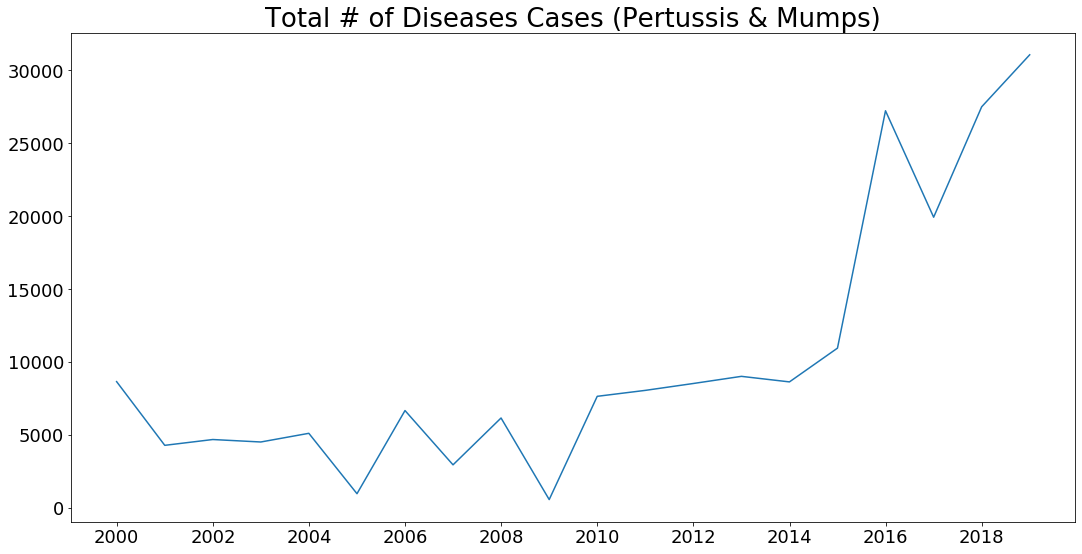

In [9]:
plot_series(df, ['Total Cases'], title = 'Total # of Diseases Cases (Pertussis & Mumps)')

**Notes**: While there is a clear upward trend, seasonsality will not be observed because we are dealing with yearly data. Even if we were to ignore that point, there is no clear pattern that occurs at specific intervals on an annual scale. The spikes up and down appear to be random without a fixed and known frequency. Also our data is not stationary so we need to difference. Our trend appears to be exponential so we will use a multiplicative model to decompose.

## Seasonality<a id='season'></a> 

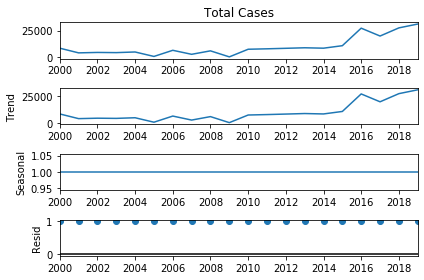

In [10]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['Total Cases'], model = 'multiplicative')

# Plot the decomposed time series.
decomp.plot();

### Model Selection: 

There is an observable trend however no seasonsality. We are also including exogenous variables with time series data so the obvious choice here is to use an **ARIMAX** model.


# Choosing P, Q, and D for ARIMAX modeling<a id='pqd'></a> 

## Choosing D<a id='d'></a> 

In [11]:
#creating first difference total cases and second differenced total cases column
df['first_diff_cases'] = df['Total Cases'].diff()
df['second_diff_cases'] = df['Total Cases'].diff().diff()
df['third_diff_cases'] = df['Total Cases'].diff().diff().diff()
df['Log Cases'] = np.log(df['Total Cases']).diff()

In [12]:
#checking to see which one we should use
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [13]:
interpret_dftest(adfuller(df['Total Cases'].dropna()))

Test Statistic    0.708021
p-value           0.989997
dtype: float64

**Comments**: P value well over .05 or .01 so we can't use our Total Cases as it is not stationary.

In [14]:
interpret_dftest(adfuller(df['first_diff_cases'].dropna()))

Test Statistic    2.493848
p-value           0.999048
dtype: float64

**Comments**: P value still greater than .05

In [15]:
interpret_dftest(adfuller(df['second_diff_cases'].dropna()))

Test Statistic    1.317082
p-value           0.996703
dtype: float64

In [16]:
interpret_dftest(adfuller(df['third_diff_cases'].dropna()))

Test Statistic   -4.548665
p-value           0.000160
dtype: float64

**Comments**: P value greater than .05.

In [17]:
interpret_dftest(adfuller(df['Log Cases'].dropna()))

Test Statistic   -4.045369
p-value           0.001191
dtype: float64

**Comments**: P value less than .05, we can use.

### D Choice: Going to model using 3rd differenced data.

## Selecting P (AR) <a id='p'></a> 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


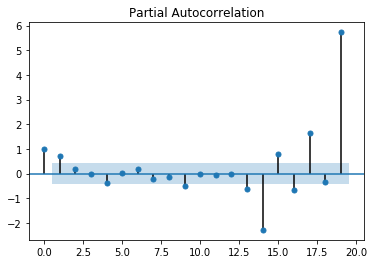

In [18]:
plot_pacf(df['Total Cases'], lags = 19);

**Notes**: There appears to be around 3 - 4 significantly large spikes or statistically significant lags based on the autocorrelation plot. Again, no evidence of seasonality. 

### Choice: Our choice for P is 3 or 4

## Selecting Q (MA) <a id='q'></a> 

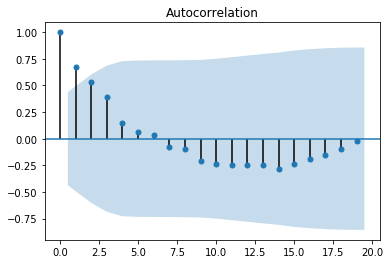

In [19]:
plot_acf(df['Total Cases'], lags = 19);

**Notes**: This represents a weakly autocorrelated which means our model will have trouble making predictions. It also tells us our autocorrelation tells us that our lags are correlated up until around 7, thie means that our data is again, not highly correlated. Although this is only one measure of randomness, this makes sense because we chose a country whose # of cases was very volatile. It also tells us that there is a trend because our first 2 values are significantly higher than the others. Clearly not stationary. There are about 2 significant lags based on the plot.

### Choice: Our choice for Q is 2.

# Selecting P and Q Using Auto Arima<a id='auto'></a> 

To validate our choice we are also checking with Auto Arima.

In [20]:
model_pq = auto_arima(
    y = df['Total Cases'],                # specify time series data source
    start_p = 0,            # gridsearch p starting from 0
    max_p = 5,              # gridsearch p ending at 5
    start_q = 0,            # gridsearch q starting from 0
    max_q = 5,              # gridsearch q ending at 5
    d = 3,                  # we know how much to difference, so don't need to waste time searching for this
    
    seasonal=False,         # ignore seasonality for now
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True)  # don't want convergence warnings

Performing stepwise search to minimize aic
Fit ARIMA: (0, 3, 0)x(0, 0, 0, 0) (constant=True); AIC=385.097, BIC=386.763, Time=0.009 seconds
Fit ARIMA: (1, 3, 0)x(0, 0, 0, 0) (constant=True); AIC=367.217, BIC=369.717, Time=0.021 seconds
Fit ARIMA: (0, 3, 1)x(0, 0, 0, 0) (constant=True); AIC=367.314, BIC=369.814, Time=0.081 seconds
Near non-invertible roots for order (0, 3, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA: (0, 3, 0)x(0, 0, 0, 0) (constant=False); AIC=383.348, BIC=384.182, Time=0.005 seconds
Fit ARIMA: (2, 3, 0)x(0, 0, 0, 0) (constant=True); AIC=362.556, BIC=365.889, Time=0.021 seconds
Fit ARIMA: (3, 3, 0)x(0, 0, 0, 0) (constant=True); AIC=356.846, BIC=361.012, Time=0.034 seconds
Fit ARIMA: (4, 3, 0)x(0, 0, 0, 0) (constant=True); AIC=358.154, BIC=363.153, Time=0.055 seconds
Fit ARIMA: (3, 3, 1)x(0, 0, 0, 0) (constant=True); AIC=353.816, BIC=358.815, Time=0.447 seconds
Fit ARIMA: (2, 3, 1)x(0, 0, 0,

**Notes**: The model that minimizes AIC is ARIMAX of order (4,3,2) or (3,3,2) which is one of the choices we derived from PACF and ACF plots.

# ARIMAX Model<a id='arimax'></a> 

## Baseline Model

For our baseline model we will just predict the mean of the number of cases which is **10145** as shown below.

**Baseline Model Prediction**: 10145

In [29]:
baseline = df['Total Cases'].as_matrix()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [30]:
baseline.mean()

10145.7

In [22]:
arimax_model = sm.tsa.statespace.SARIMAX(y_train,order=(3,2,2),seasonal_order=(0,0,0,0),exog = X_train, freq='Y',
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arimax_model.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Total Cases   No. Observations:                   16
Model:               SARIMAX(3, 2, 2)   Log Likelihood                  54.183
Date:                Wed, 11 Mar 2020   AIC                            -64.366
Time:                        16:06:35   BIC                            -55.612
Sample:                    12-31-1999   HQIC                           -69.884
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
================================================================================================================================================
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------
ICT goods exports (% of total goods exports)                                 -1248.9927   1.21e-10  -1.03e+13      0.000   -1248.993   -1248.993
Individuals using the Internet (% of population)                              1362.2166   7.12e-11   1.91e+13      0.000    1362.217    1362.217
Fixed telephone subscriptions (per 100 people)                                2838.9980   4.56e-10   6.22e+12      0.000    2838.998    2838.998
Air transport, freight (million ton-km)                                        -20.2802   1.97e-08  -1.03e+09      0.000     -20.280     -20.280
Industrial design applications, nonresident, by count                          -25.1441   4.59e-11  -5.47e+11      0.000     -25.144     -25.144
Public private partnerships investment in water and sanitation (current US$)  6.658e-06   7.75e-13   8.59e+06      0.000    6.66e-06    6.66e-06
Public private partnerships investment in transport (current US$)             3.404e-08   2.38e-13   1.43e+05      0.000     3.4e-08     3.4e-08
Electricity production from natural gas sources (% of total)                   -15.0616   1.09e-09  -1.38e+10      0.000     -15.062     -15.062
ICT service exports (% of service exports, BoP)                               4341.4583      2e-10   2.17e+13      0.000    4341.458    4341.458
Healthcare Expenditure Percent GDP                                            2566.2142   6.87e-11   3.73e+13      0.000    2566.214    2566.214
Pharmaceutical Spending US $ / Capita                                          -64.9020   1.61e-08  -4.03e+09      0.000     -64.902     -64.902
CT Scan Device Counts                                                          -67.9586   1.65e-08  -4.12e+09      0.000     -67.959     -67.959
PET Scan Device Counts                                                       -1143.1798   6.05e-10  -1.89e+12      0.000   -1143.180   -1143.180
Doctors per 1000 People                                                        256.0590   2.43e-11   1.05e+13      0.000     256.059     256.059
Nurses per 1000 People                                                         -18.9952   1.75e-11  -1.09e+12      0.000     -18.995     -18.995
Hospital Count                                                                  21.9078   2.38e-08   9.22e+08      0.000      21.908      21.908
ar.L1                                                                           -0.3496   3.82e-13  -9.16e+11      0.000      -0.350      -0.350
ar.L2                                                                            0.4364   7.34e-13   5.95e+11      0.000       0.436       0.436
ar.L3                                                                           -0.2288    5.6e-13  -4.09e+11      0.000      -0.229      -0.229
ma.L1                                              

## Plotting Predictions<a id='preds'></a> 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


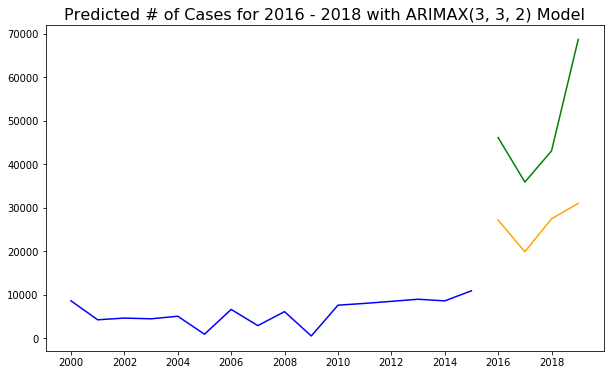

In [23]:
# Instantiate and fitting best model.
model = sm.tsa.statespace.SARIMAX(y_train, order=(3,3,2), seasonal_order=(0,0,0,0), exog = X_train, freq='Y',
                                  enforce_stationarity=False, enforce_invertibility=False).fit()

# Generate predictions based on test set.
preds = model.predict(paramters = model.params,
                       exog = X_test,
                       start = y_test.index[0],
                       end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted # of Cases for 2016 - 2018 with ARIMAX(3, 3, 2) Model', fontsize=16)
plt.show();

### Evaluating Our Predictions<a id='eval'></a>

In [39]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

23867.98808210073

In [40]:
#looking at our predictions
preds

2015-12-31    46173.973544
2016-12-31    35944.249849
2017-12-31    43095.485999
2018-12-31    68716.820483
Freq: A-DEC, dtype: float64

In [42]:
#looking at our actual data
y_test

2015-12-31    27214.0
2016-12-31    19917.0
2017-12-31    27486.0
2018-12-31    31051.0
Name: Total Cases, dtype: float64

**Notes**: On average our prediction was off by 23867 cases. It should be noted that differencing by 2 produced an RMSE of approx. 9000 but we could not do that per p value rules. Our predictions aren't too far off in 2016 but are very off in 2018, likely because our model is using the exponential nature of our original data and extrapolating. This was expected with our limited data. This model performs worse than our baseline of predicting the mean because the difference between predictions and actual is greater with our model.

## Plotting Residuals<a id='resid'></a> 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


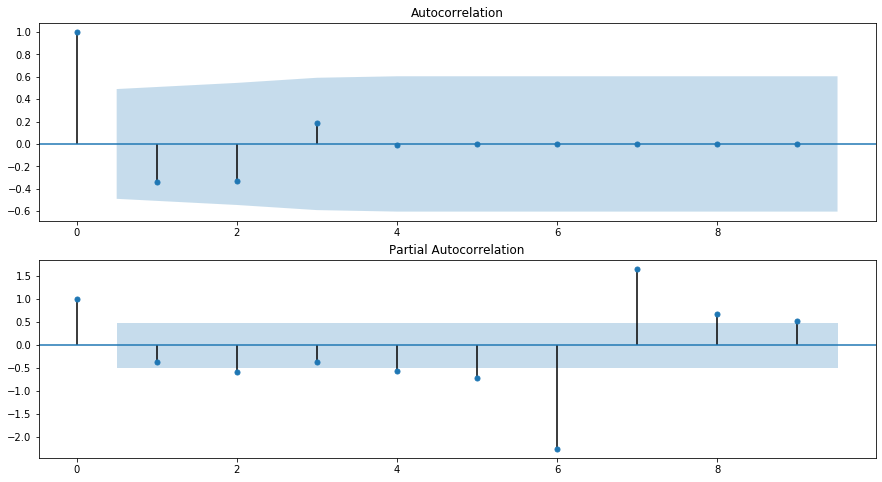

In [25]:
res = model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=9, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=9, ax=ax[1])
plt.show()

# Analysis & Findings<a id='analysis'></a> 

From plotting our predictions, our model does an OK job of predicting values in 2016 however struggles in 2018. This is likely because our original data represented an exponential function leading to the model overshooting estimates. This is one of the problems with having little data is that we are zoomed in to a small time frame. 20 years of disease and infrastructure data is relatively small so while in the last 5 or so years the number of viral cases has gone up in an exponential fashion, it is likely not representative of the actual pattern of outbreaks which is proabably more like an oscillation. We don't have data prior to 1999 that could confirm this. Obviously with more data this model improves. 



Although the model does not have much data to test on, the coeffecients on our exogenousv variables or infrastructure can offer us valuable insight on the validity of our orignal hypothesis and help direct our next steps. Some interesting coeffeceints to note were:
* For every 1% increase in people using the internet, the number of cases goes up approximately 1300.
* For every 1 increase in telephone subscriptions per 100 people the number of cases goes up approximately 2800.
* For every 1 million dollars spent on sanitation and water the number of cases only goes down 6.
* For every 1% in Healthcare spendind as a portion of GDP the number of cases goes up 2500.
* For every additional PET scanner the number of cases goes down approximately 1150.
* For every 1 additional doctor per 1000 people the number of cases goes up 256.
* For every additional hospital the number of cases increase.

# Next Steps<a id='next'></a> 

Differencing at an order of 3 is not ideal however was required based on our AD Fuller test. For the next step we will most likely use a Vector Autoregression Model (VAR) for this data. 

Additionally the hypothesis likely needs to be modified based on observed relations between infrastrcture and viral cases and through the coeffecients on our model. Our original theory was not completely accurate as shown by the model as different parts of infrastructure show different effects on viral cases. The next logical step would to limit the scope of our model and problem we are trying to solve. Health infrastrcture, and non-health infrastructure have different effects on the spread of disease. We would likely focus on one aspect of infrastructure such as transportation, healthcare, communication, etc. Additionally we would want to investigate further the causal relationship between variables. Does infrastructure respond to increased spread of disease? Or is the spread of disease the function of infrastructure? Or do neither of these relationships matter? 

While this model might not offer the breadth of insight we were hoping for, it does provide insight on which areas we should focus on next.